# 14. 전이 학습 활용하기

https://codetorial.net/tensorflow/transfer_learning.html

전이 학습(Transfer learning)은 사전 훈련된 모델을 그대로 불러와서 활용하는 학습 방식입니다.

전이 학습을 사용하면 직접 다루기 힘든 대량의 데이터셋으로 사전 훈련된 특성들을 손쉽게 활용할 수 있습니다.

이 페이지에서는 ImageNet 데이터셋을 잘 분류하도록 사전 훈련된 InceptionV3 모델의 가중치를 불러와서 개와 이미지를 분류하는데 활용하는 과정에 대해 소개합니다.

## 사전 훈련된 가중치 다운로드하기

Google Colab환경에서 아래의 명령어를 실행하면, tmp 폴더에 미리 훈련된 가중치가 다운로드 됩니다.

주소에 직접 접속해서 로컬 환경에 다운로드 받을 수도 있습니다.

In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
  -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-04-12 06:15:04--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  82.5MB/s    in 1.0s    

2022-04-12 06:15:05 (82.5 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Goole Colab환경에서 아래와같이 tmp 폴더에 파일이 생겼다면 전이 학습(Transfer learning)을 활용할 준비가 되었습니다.

In [5]:
import os
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150,150,3), include_top=False, weights=None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                       

tensorflow.keras.applications 모듈은 사전 훈련된 가중치를 갖고 있는 다양한 신경망 구조를 포함합니다.

예제에서는 이 tensorflow.keras.applications 모듈의 inception_v3 모듈로부터 불러온 InceptionV3 함수를 사용해서 InceptionV3 모델을 구성합니다. InceptionV3 모델에 대해서는 링크를 참고하세요.
https://en.wikipedia.org/wiki/Inceptionv3
https://arxiv.org/pdf/1512.00567.pdf

InceptionV3 모델은 상단 (출력층과 가까운 신경망의 끝부분)에 완전 연결된 뉴런층을 포함합니다.

include_top는 이러한 완전 연결된 뉴런층의 포함 여부를 설정합니다.

weights는 적용할 가중치를 지정합니다.
 - None: 임의로 초기화(random initialization)된 가중치를 적용합니다.
 - imagenet: ImageNet에 대해 사전 훈련된 가중치를 적용합니다. (Default)

그 다음으로 load_weights() 메서드를 사용해서 미리 다운로드한 가중치를 InceptionV3 모델에 적용합니다.

layer.trainable는 뉴런층의 가중치의 훈련 가능 여부를 설정합니다.

summary() 메서드로 구성한 모델의 구조를 출력했습니다.

매우 많은 수의, 그리고 다양한 뉴런층이 포함되어 있음을 알 수 있습니다.

InceptionV3 모델의 구조를 그림으로 나타내면 아래와 같습니다.

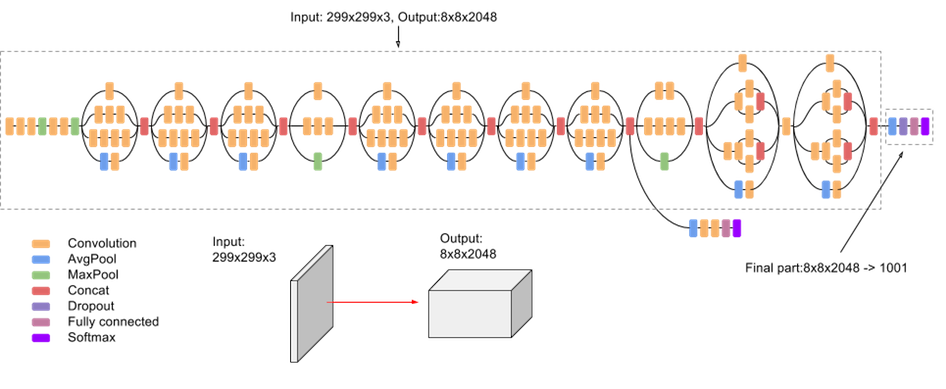



## 마지막 층 출력 확인하기

In [6]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


TensorFlow로 구성된 모델의 모든 뉴런층에는 이름이 있습니다.

앞에서 summary() 메서드로 모든 뉴런층의 이름을 출력했습니다.

'mixed7'라는 이름을 갖는 층을 가져와서 사전 훈련된 신경망 모델의 마지막 층으로 지정했습니다.

## 모델 구성/컴파일하기

In [10]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(lr=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

#model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


                                                                                                  
 conv2d_206 (Conv2D)            (None, 16, 16, 64)   16384       ['average_pooling2d_19[0][0]']   
                                                                                                  
 batch_normalization_200 (Batch  (None, 16, 16, 64)  192         ['conv2d_200[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_202 (Batch  (None, 16, 16, 64)  192         ['conv2d_202[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_205 (Batch  (None, 16, 16, 96)  288         ['conv2d_205[0][0]']             
 Normaliza

Flatten()는 앞에서 지정한 InceptionV3 모델의 마지막 층의 출력을 1차원으로 변환합니다.

Dense()는 완전 연결된 뉴런층을 추가합니다.

두 개의 뉴런층을 추가하고 활성화 함수를 각각 'relu'와 'sigmoid'로 지정했습니다.

Model()클래스에 InceptionV3모델의 입력과 새롭게 구성한 뉴런층을 입력함으로써 새로운 모델을 만들었습니다.

compile()을 사용해서 구성한 모델을 컴파일합니다.

## 데이터셋 다운로드하기

사전 훈련된 가중치를 평가하기 위한 Kaggle Vs Cats 데이터셋을 준비합니다.

Kaggle Dogs Vs Cats 데이터셋에 대해서는 고양이와 개 이미지 분류하기 페이지를 참고하세요.

In [11]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2022-04-12 06:52:15--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   251MB/s    in 0.3s    

2022-04-12 06:52:16 (251 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [12]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r') # zip 폴더 불러오기
zip_ref.extractall('/tmp') # 해당 경로에 압축풀기
zip_ref.close()

우선 Colab 코드셀에 위의 명령어를 입력해서 데이터셋을 다운로드합니다.

아래 그림과 같이 페이지 왼쪽의 목차 탭을 열어서 tmp 폴더에 cats_and_dogs_filtered.zip 파일이 다운로드되어 있는지 확인합니다.

cats_and_dogs_filtered.zip 파일이 준비되어 있다면 압축을 풀어줍니다.

## 데이터 어그멘테이션

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='binary', target_size=(150,150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir, batch_size=20, class_mode = 'binary', target_size=(150,150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


이미지 어그멘테이션의 효과 페이지에서 다루었던대로 훈련 데이터에 대해 어그멘테이션을 활용합니다.

테스트 이미지에 대해서는 어그멘테이션을 수행하지 않고, 데이터 리스케일만 수행합니다.

## 모델 훈련하기

In [14]:
history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch=100, epochs = 20, validation_steps=50, verbose=2)

Epoch 1/20
100/100 - 154s - loss: 1.4153 - accuracy: 0.8305 - val_loss: 0.3504 - val_accuracy: 0.8790 - 154s/epoch - 2s/step
Epoch 2/20
100/100 - 178s - loss: 0.3005 - accuracy: 0.8985 - val_loss: 0.1007 - val_accuracy: 0.9620 - 178s/epoch - 2s/step
Epoch 3/20
100/100 - 145s - loss: 0.2859 - accuracy: 0.9155 - val_loss: 0.0923 - val_accuracy: 0.9650 - 145s/epoch - 1s/step
Epoch 4/20
100/100 - 143s - loss: 0.2501 - accuracy: 0.9125 - val_loss: 0.0872 - val_accuracy: 0.9660 - 143s/epoch - 1s/step
Epoch 5/20
100/100 - 142s - loss: 0.2238 - accuracy: 0.9240 - val_loss: 0.1550 - val_accuracy: 0.9570 - 142s/epoch - 1s/step
Epoch 6/20
100/100 - 142s - loss: 0.1926 - accuracy: 0.9280 - val_loss: 0.1266 - val_accuracy: 0.9650 - 142s/epoch - 1s/step
Epoch 7/20
100/100 - 142s - loss: 0.1887 - accuracy: 0.9400 - val_loss: 0.1403 - val_accuracy: 0.9670 - 142s/epoch - 1s/step
Epoch 8/20
100/100 - 142s - loss: 0.1957 - accuracy: 0.9295 - val_loss: 0.2076 - val_accuracy: 0.9490 - 142s/epoch - 1s/step


## 훈련결과 확인하기

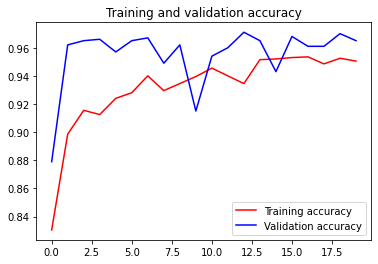

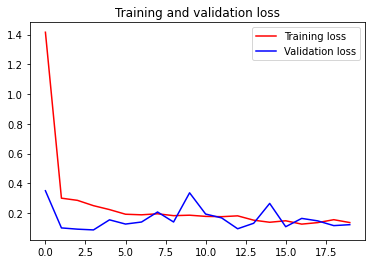

In [17]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()


plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()